In [1]:
from robot_properties_solo.solo12wrapper import Solo12Config
import pinocchio as pin
from scipy.spatial.transform import Rotation
from mim_data_utils import DataReader
import matplotlib.pylab as plt
import numpy as np

np.set_printoptions(suppress=True, precision=4, sign=' ')

plt.rcParams['figure.dpi'] = 144  # makes plots bigger, default = 72.0

In [2]:
from filterpy.kalman import KalmanFilter

# Read, Filter, and Calculate Data

In [3]:
pin_robot = Solo12Config.buildRobotWrapper()
reader = DataReader('2021-07-20_11-10-52_reactive.mds')

In [4]:
reader_q = reader.data['q']
reader_dq = reader.data['dq']
reader_tau = reader.data['tau']
reader_vicon_leg = reader.data['vicon_leg_hl']
reader_imu = reader.data['imu_gyroscope']

calculated_f = np.empty((reader_q.shape[0], 4, 3))
calculated_omi = np.empty((reader_q.shape[0], 3))

In [5]:
kf = KalmanFilter(dim_x=37, dim_z=37)  # count velocity as measurement, for now
kf.x = np.hstack((reader_q[0], reader_dq[0]))
pre_quat = np.eye(37, k=19)
pre_quat[3:] = 0
post_quat = np.eye(37, k=18)
post_quat[:7] = 0

kf.F = np.eye(37) + 0.001*(pre_quat + post_quat)
kf.H = np.eye(37)  # meausrement
kf.R = np.eye(37)  # covariance
kf.Q = 0  # nosie

In [6]:
# for i in range(10):
#     print(kf.F[i],'\n', i, np.argwhere(kf.F[i] == 0.001))

In [7]:
filtered_q_dq = np.empty((5001, 37))
filtered_q_dq[0] = np.hstack((reader_q[0], reader_dq[0]))

In [8]:
for ms in range(1, reader_q.shape[0]):
    kf.predict()
    kf.update(np.hstack((reader_q[ms], reader_dq[ms])))
#     kf.update(reader_q[ms])
    
    filtered_q_dq[ms] = kf.x
    

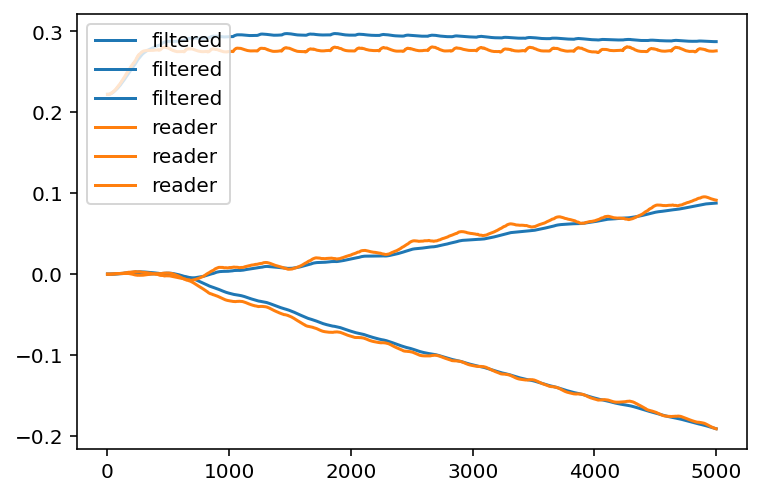

In [9]:
plt.plot(filtered_q_dq[:, :3], color='C0', label='filtered')
plt.plot(reader_q[:, :3], color='C1', label='reader')
plt.legend();

In [10]:
# calculate filtered f
filtered_f = np.empty((5001, 4, 3))
for ms in range(reader_q.shape[0]):
    q = filtered_q_dq[ms, :19]
    dq = filtered_q_dq[ms, 19:]
    pin_robot.computeJointJacobians(q)

    for i, endeff_name in enumerate(['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']):
        frame_id = pin_robot.model.getFrameId(endeff_name)
        pin_robot.framePlacement(q, index=frame_id)
        J = pin_robot.getFrameJacobian(
            frame_id=frame_id, rf_frame=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
        J_inv = np.linalg.pinv(J[:3, 6 + 3 * i:9 + 3 * i].T) * -1
        h = pin_robot.nle(q, dq)
        F = np.hstack((np.zeros(6), reader_tau[ms][6:]))
        filtered_f[ms, i] = J_inv @ ((F - h)[6 + 3 * i:9 + 3 * i])

In [11]:
# calculate f
for ms in range(reader_q.shape[0]):
    q = reader_q[ms]
    dq = reader_dq[ms]
    pin_robot.computeJointJacobians(q)

    for i, endeff_name in enumerate(['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']):
        frame_id = pin_robot.model.getFrameId(endeff_name)
        pin_robot.framePlacement(q, index=frame_id)
        J = pin_robot.getFrameJacobian(
            frame_id=frame_id, rf_frame=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
        J_inv = np.linalg.pinv(J[:3, 6 + 3 * i:9 + 3 * i].T) * -1
        h = pin_robot.nle(q, dq)
        F = np.hstack((np.zeros(6), reader_tau[ms][6:]))
        calculated_f[ms, i] = J_inv @ ((F - h)[6 + 3 * i:9 + 3 * i])

# plt.plot(calculated_f[:, :, 2])

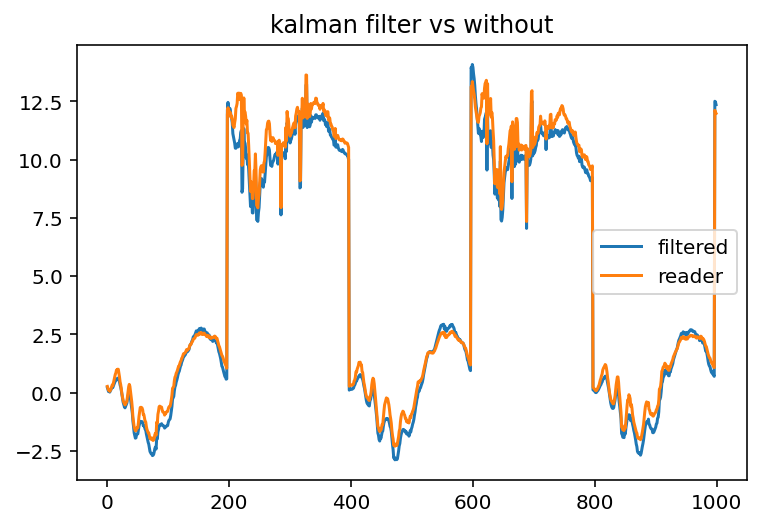

In [12]:
s = slice(1000, 2000)
plt.plot(filtered_f[s, 2, 2], label='filtered')
plt.plot(calculated_f[s, 2, 2], label='reader')
plt.title("kalman filter vs without")
plt.legend();

# Plot Data

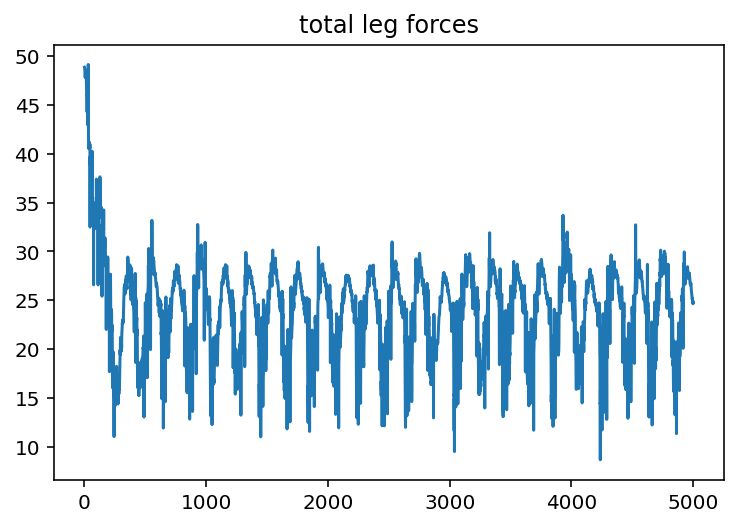

In [13]:
plt.plot(np.sum(calculated_f[:, :, 2], axis=1), label='a')
plt.title('total leg forces')
a = reader

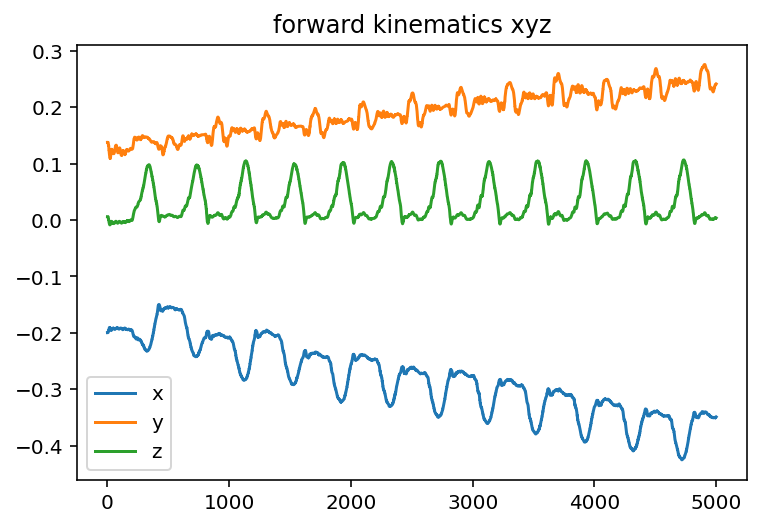

In [15]:
# plot xyz of forward kinematics
forwardK = np.empty((reader_q.shape[0], 3))
# for i_omi in range(1, 14):
for ms in range(reader_q.shape[0]):
    q = reader_q[ms]
    # dq = all_dq[ms]
    pin_robot.computeJointJacobians(q)
#     pin_robot.forwardKinematics(q)
    pin_robot.framesForwardKinematics(q)
    forwardK[ms] = pin_robot.data.oMf[pin_robot.model.getFrameId('HL_ANKLE')].translation

plt.plot(forwardK)
plt.legend('xyz')
plt.title('forward kinematics xyz')
plt.show()

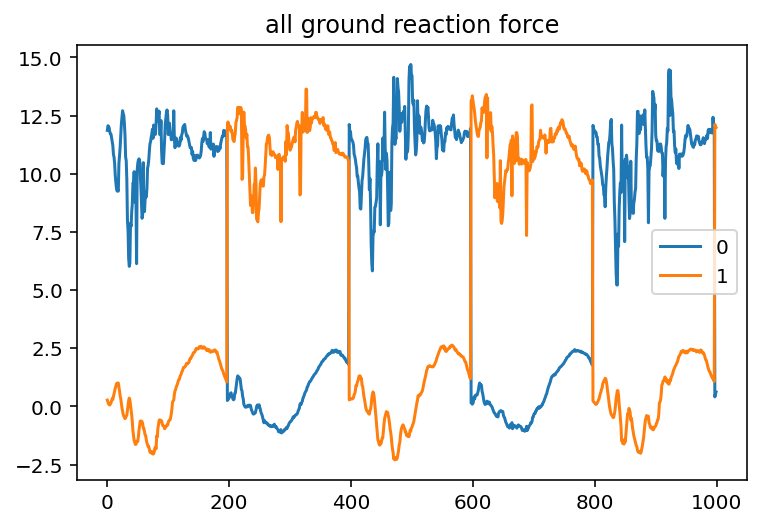

In [16]:
# plot GRF
plt.plot(calculated_f[1000:2000, ::2, 2])
plt.title('all ground reaction force')
plt.legend(range(4))

Text(0.5, 1.0, 'sum of leg forces minus gravity force')

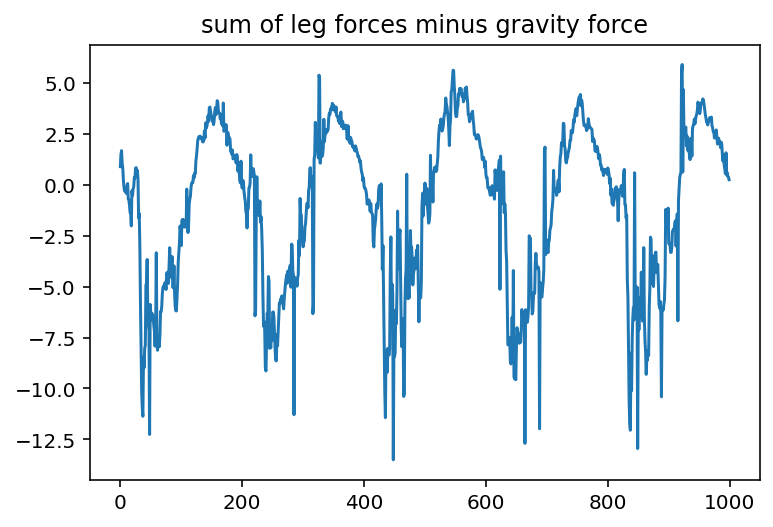

In [17]:
# plot the sum of all leg forces
m_robot = np.sum([i.mass for i in pin_robot.model.inertias])
plt.plot(np.sum(calculated_f[1000:2000, :, 2], axis=1) - m_robot * 9.81)
plt.title("sum of leg forces minus gravity force")

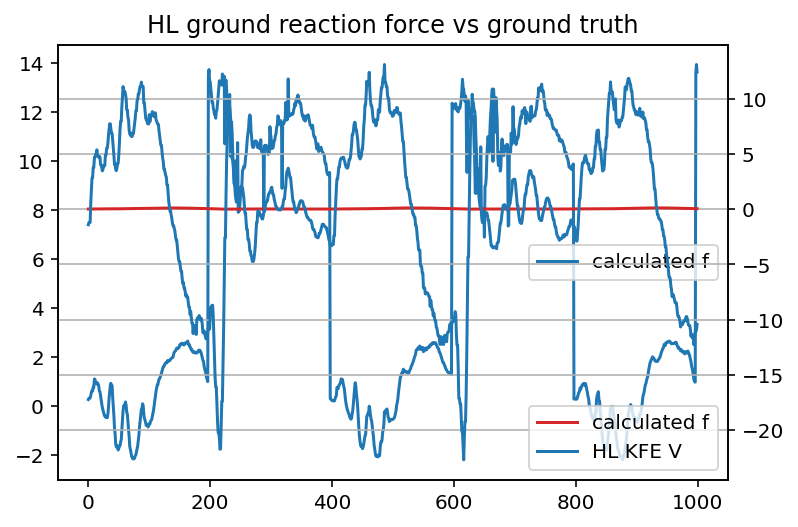

In [34]:
# compare calculated f and z values of forward kinematics
s = slice(3000, 4000)
plt.plot(calculated_f[s, 2, 2], label='calculated f')
plt.legend()
tw = plt.twinx()
tw.plot(forwardK[s, 2], label='forward k', color='C3')
tw.legend()
plt.plot(reader.data['joint_velocities'][s, 8],)
# plt.plot(all_imu[1000:2000, 0] * 8)
plt.title('HL ground reaction force vs ground truth')
plt.legend(('calculated f', 'HL KFE V'))
plt.grid()
# plt.legend()

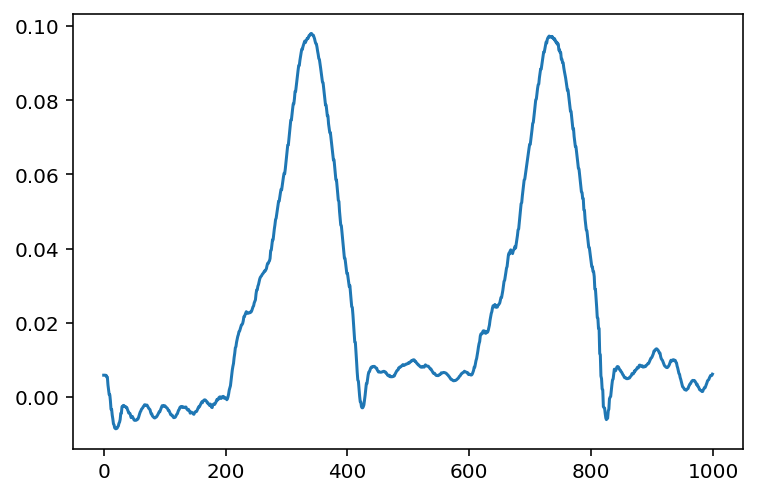

In [30]:
plt.plot(forwardK[0:1000, 2])

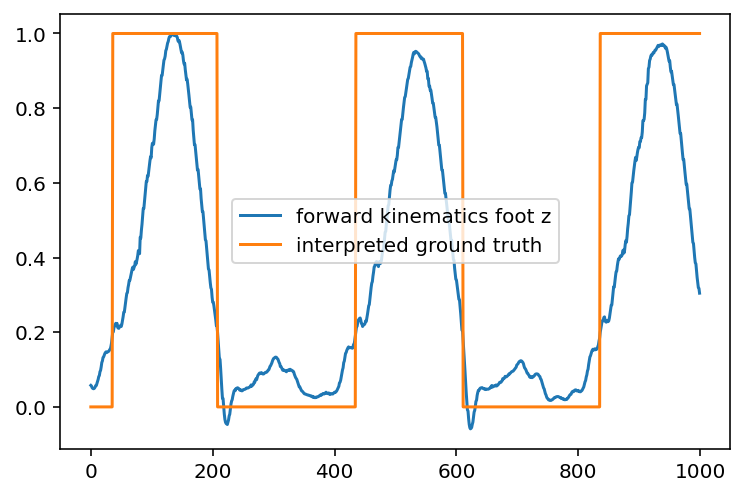

In [14]:
plt.plot(forwardK[1000:2000, 2]/np.max(forwardK[1000:2000:, 2]), label='forward kinematics foot z')
plt.plot(np.where(forwardK[1000:2000, 2]/np.max(forwardK[1000:2000:, 2]) > 0.2, 1, 0), label='interpreted ground truth')
plt.plot()
plt.legend()

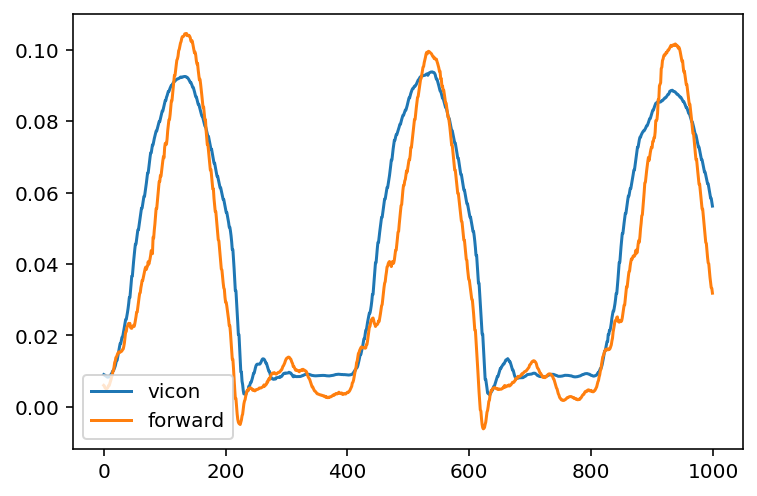

In [15]:
slice_compare_viconforwardK = slice(1000,2000)
plt.plot(reader_vicon_leg[slice_compare_viconforwardK, 2], label='vicon')
plt.plot(forwardK[slice_compare_viconforwardK, 2], label='forward')
plt.legend()

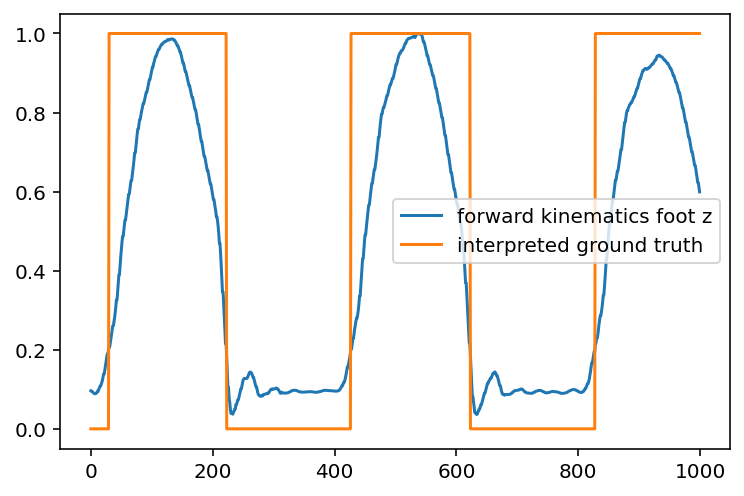

In [16]:
plt.plot(reader_vicon_leg[1000:2000, 2]/np.max(
    reader_vicon_leg[1000:2000:, 2]), label='forward kinematics foot z')
plt.plot(np.where(reader_vicon_leg[1000:2000, 2]/np.max(
    reader_vicon_leg[1000:2000:, 2]) > 0.2, 1, 0), label='interpreted ground truth')
plt.plot()
plt.legend()

Text(0.5, 1.0, 'body')

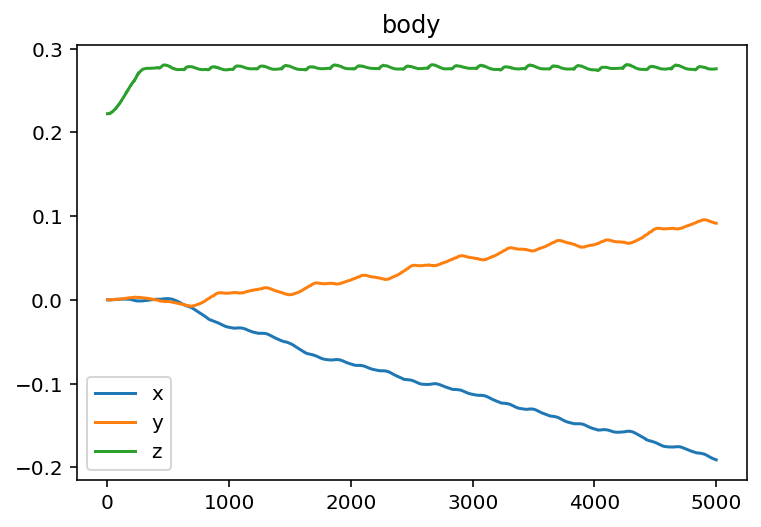

In [17]:
plt.plot(reader_q[:, :3])
plt.legend('xyz')
plt.title('body')

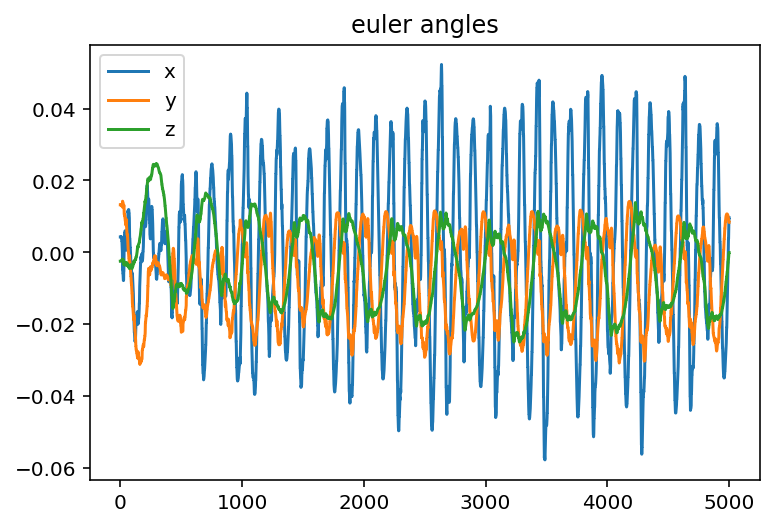

In [19]:
calculated_euler_angles = Rotation.from_quat(reader_q[:, 3:7]).as_euler('xyz')
plt.plot(calculated_euler_angles)
plt.title('euler angles')
plt.legend('xyz')

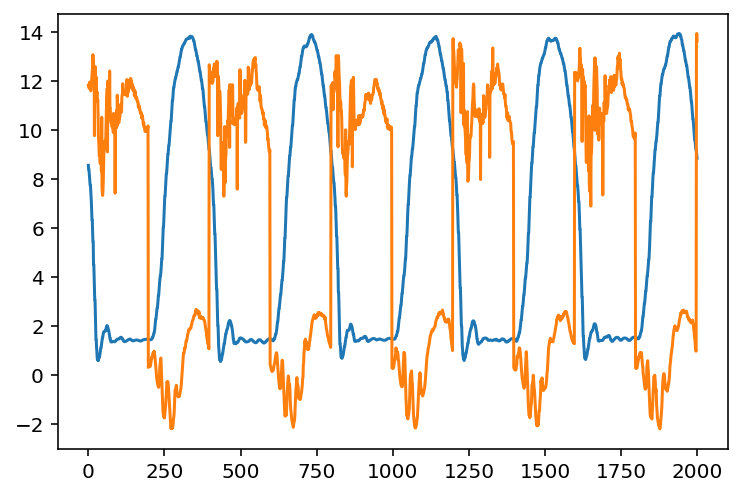

In [20]:
slice_viconcalculatedF = slice(2000, 4000)
plt.plot(reader_vicon_leg[slice_viconcalculatedF, 2] * 1/np.max(reader_vicon_leg[slice_viconcalculatedF, 2]) * np.max(calculated_f[slice_viconcalculatedF, 2, 2]))
plt.plot(calculated_f[slice_viconcalculatedF, 2, 2])

In [21]:
np.sum([i.mass for i in pin_robot.model.inertias]) * 9.81
# 24.5

24.525027369900005